In [1]:
# 1. Imports y configuración
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from transformers import AutoTokenizer, TFAutoModel

RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

C:\Users\50250\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# 1.1. Rutas a tus CSV ya limpiados
TRAIN_PATH = "../data/train_model.csv"
VAL_PATH   = "../data/val_model.csv"
TEST_PATH  = "../data/test_model.csv"

# 1.2. Cargar datos
df_train = pd.read_csv(TRAIN_PATH)
df_val   = pd.read_csv(VAL_PATH)
df_test  = pd.read_csv(TEST_PATH)

In [3]:
# Usamos el texto limpio
X_train_text = df_train["clean_body"].fillna("").astype(str)
y_train      = df_train["rule_violation"].astype(int)

X_val_text   = df_val["clean_body"].fillna("").astype(str)
y_val        = df_val["rule_violation"].astype(int)

X_test_text  = df_test["clean_body"].fillna("").astype(str)

print(df_train.shape, df_val.shape, df_test.shape)
print(df_train["rule_violation"].value_counts(normalize=True))

(1623, 2) (406, 2) (10, 2)
rule_violation
1    0.508318
0    0.491682
Name: proportion, dtype: float64


In [4]:
# 2.1. Cargar tokenizer de un modelo base
MODEL_NAME = "distilbert-base-uncased"  # modelo en inglés, bueno para Reddit

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 160  # longitud máxima del comentario (puedes ajustar 128–256)
BATCH_SIZE = 16

def encode_texts(texts):
    """
    Aplica el tokenizer a una lista de strings y devuelve tensores TF.
    """
    enc = tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="tf"
    )
    return enc["input_ids"], enc["attention_mask"]

# 2.2. Crear datasets de entrenamiento y validación
train_input_ids, train_attn = encode_texts(X_train_text)
val_input_ids,   val_attn   = encode_texts(X_val_text)
test_input_ids,  test_attn  = encode_texts(X_test_text)

y_train_tf = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
y_val_tf   = tf.convert_to_tensor(y_val.values,   dtype=tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_input_ids, "attention_mask": train_attn},
    y_train_tf
))
val_ds = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_input_ids, "attention_mask": val_attn},
    y_val_tf
))
test_ds = tf.data.Dataset.from_tensor_slices(
    {"input_ids": test_input_ids, "attention_mask": test_attn}
)

train_ds = train_ds.shuffle(len(df_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [5]:
# 3.1. Cargar backbone pre-entrenado
backbone = TFAutoModel.from_pretrained(MODEL_NAME)

# 3.2. Definir arquitectura
input_ids      = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

# Salida de DistilBERT
outputs = backbone(input_ids, attention_mask=attention_mask)
# outputs.last_hidden_state: [batch, seq_len, hidden_size]
cls_token = outputs.last_hidden_state[:, 0, :]  # vector de la posición [CLS]

x = tf.keras.layers.Dropout(0.3)(cls_token)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
logits = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=logits)

# 3.3. Compilar
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.AUC(name="auc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=METRICS,
)

model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 160)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 160)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 160, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                       

In [6]:
# 4.1. Directorios para guardar todo
CKPT_DIR   = "./Modelo_1/checkpoints_rule_model"
LOGS_DIR   = "./Modelo_1/logs_rule_model"
SAVED_DIR  = "./Modelo_1/best_rule_model"

os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(SAVED_DIR, exist_ok=True)

ckpt_path = os.path.join(CKPT_DIR, "best_weights")

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    save_weights_only=True,
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1,
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=3,
    restore_best_weights=True,
    verbose=1,
)

reduceLR_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc",
    mode="max",
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1,
)

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=LOGS_DIR,
    histogram_freq=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduceLR_cb, tensorboard_cb]

# 4.2. (Opcional) cargar pesos previos si ya existe un checkpoint
if os.path.exists(ckpt_path + ".index"):
    print("Cargando pesos desde checkpoint previo...")
    model.load_weights(ckpt_path)


In [7]:
EPOCHS = 10  # con early stopping normalmente se corta antes

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

# Guardar el modelo completo en formato Keras (para reusar fácilmente)
model.save(SAVED_DIR)

# Evaluación final en validación
val_metrics = model.evaluate(val_ds, verbose=2)
print(dict(zip(model.metrics_names, val_metrics)))


Epoch 1/10
102/102 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.6174 - auc: 0.6731 - precision: 0.6123 - recall: 0.6739
Epoch 1: val_auc improved from -inf to 0.80856, saving model to ./Modelo_1/checkpoints_rule_model\best_weights
102/102 [==============================] - 499s 5s/step - loss: 0.6388 - accuracy: 0.6174 - auc: 0.6731 - precision: 0.6123 - recall: 0.6739 - val_loss: 0.5512 - val_accuracy: 0.7291 - val_auc: 0.8086 - val_precision: 0.7892 - val_recall: 0.6359 - lr: 2.0000e-05
Epoch 2/10
102/102 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.7579 - auc: 0.8390 - precision: 0.7578 - recall: 0.7697
Epoch 2: val_auc improved from 0.80856 to 0.85665, saving model to ./Modelo_1/checkpoints_rule_model\best_weights
102/102 [==============================] - 457s 4s/step - loss: 0.4939 - accuracy: 0.7579 - auc: 0.8390 - precision: 0.7578 - recall: 0.7697 - val_loss: 0.4986 - val_accuracy: 0.7512 - val_auc: 0.8567 - val_precision: 

INFO:tensorflow:Assets written to: ./Modelo_1/best_rule_model\assets


26/26 - 35s - loss: 0.4986 - accuracy: 0.7512 - auc: 0.8567 - precision: 0.7043 - recall: 0.8786 - 35s/epoch - 1s/step
{'loss': 0.4985559284687042, 'accuracy': 0.7512315511703491, 'auc': 0.8566504716873169, 'precision': 0.7042801380157471, 'recall': 0.8786407709121704}


In [8]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

# Hacer predicciones con el modelo (probabilidades)
y_pred_prob = model.predict(val_ds).ravel()

# Convertir probabilidades a clases (0/1) con threshold 0.5
y_pred = (y_pred_prob >= 0.5).astype(int)

# y_val_real viene del dataframe original
y_true = df_val["rule_violation"].values

# Reporte de clasificación
print(classification_report(y_true, y_pred))

# F1-score general
print("F1:", f1_score(y_true, y_pred))


26/26 [==============================] - 40s 1s/step
              precision    recall  f1-score   support

           0       0.83      0.62      0.71       200
           1       0.70      0.88      0.78       206

    accuracy                           0.75       406
   macro avg       0.77      0.75      0.75       406
weighted avg       0.77      0.75      0.75       406

F1: 0.7818574514038877


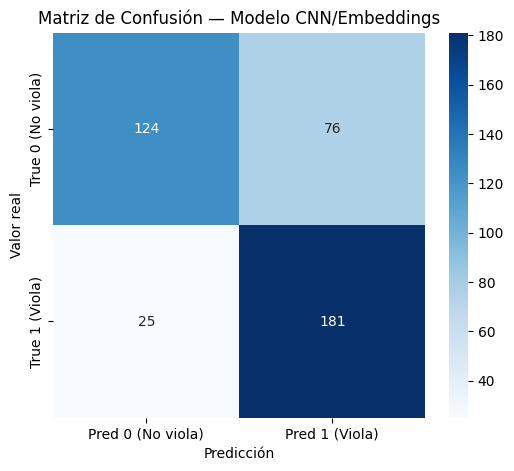

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0 (No viola)", "Pred 1 (Viola)"],
            yticklabels=["True 0 (No viola)", "True 1 (Viola)"])
plt.title("Matriz de Confusión — Modelo CNN/Embeddings")
plt.ylabel("Valor real")
plt.xlabel("Predicción")
plt.show()
